In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime, date
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Our dataset is a set of issues of a newspaper called *The Liberator* <https://en.wikipedia.org/wiki/The_Liberator_(newspaper)>, which was active for the last few decades of the abolitionist period.

In [2]:
#files = sorted(glob('TheLily/*'))
files = sorted(glob('TheLiberator/*'))

In [3]:
files[-3:]

['TheLiberator/1864-07-01.txt',
 'TheLiberator/1865-09-01.txt',
 'TheLiberator/1865-12-01.txt']

Let's build a vectorizer to read it in. 

Note the flag `binary`. If we set `binary=True`, this would mean that each word is counted at most once per document.

In [25]:
vect = CountVectorizer(input='filename',min_df=10,binary=False)

In [26]:
X = vect.fit_transform(files)

In [27]:
X.shape

(59, 8305)

**Your turn**: build another vectorizer, which includes all words that appear in at least 20 documents

In [28]:
vect2 = CountVectorizer(input='filename', min_df=20, binary=False) #your code
X2 = vect2.fit_transform(files)
print(X2.shape)

(59, 4547)


Let's print the most common words in 1851. To do this, we'll import `dateutil.parser`, which can parse the dates from the filenames.

In [29]:
from dateutil.parser import parse

In [30]:
parse(os.path.basename(files[4])[:-4])

datetime.datetime(1833, 6, 1, 0, 0)

In [31]:
# this list comprehension parses each of the dates in the filenames
dates = [parse(os.path.basename(filename)[:-4],'')
         for filename 
         in files]

In [32]:
print(dates[-3:])
print(files[-3:])

[datetime.datetime(1864, 7, 1, 0, 0), datetime.datetime(1865, 9, 1, 0, 0), datetime.datetime(1865, 12, 1, 0, 0)]
['TheLiberator/1864-07-01.txt', 'TheLiberator/1865-09-01.txt', 'TheLiberator/1865-12-01.txt']


Now we want to select a slice of X, corresponding only to editions in 1851.

We'll use the `enumerate` function to find the indices of dates that match the desired condition.

In [33]:
[(i,date) for i,date in enumerate(dates) if date.year==1851]

[(34, datetime.datetime(1851, 8, 1, 0, 0)),
 (35, datetime.datetime(1851, 11, 1, 0, 0))]

In [34]:
X_1851 = X[[i for i,date in enumerate(dates) if date.year==1851],]

In [35]:
X_1851.shape

(2, 8305)

So `X_1851` contains two instances, corresponding to the two editions published in 1851. (Actually, we're working with a small sample of the full dataset, there were several other editions published in that year.)

To find the most common words in this sample, let's construct an inverted index from the columns of `X` back to the vocabulary. 

In [36]:
ivoc = {j:i for i,j in vect.vocabulary_.items()}

In [37]:
[ivoc[i] for i in np.array(X_1851.sum(axis=0))[0].argsort()[::-1][:5]]

['the', 'of', 'and', 'to', 'in']

Not too interesting, but we're just getting started. 

**Your turn** Build a matrix containing the counts for editions published in the 1860s.

In [38]:
X_1860s = X[[i for i,date in enumerate(dates) if date.year>=1860 and date.year<=1869],]

In [39]:
# make sure you verify this
X_1860s.shape

(11, 8305)

# Pointwise mutual information

Rather than look at the most common words in each year or set of years, let's look at the words that have high *pointwise mutual information* with the year. This is defined as:

\begin{equation}
PMI(i,j) = \log \frac{P(i,j)}{P(i)\times P(j)} = \log P(i,j) - \log P(i) - \log P(j)
\end{equation}

We'll now introduce code to compute each part of this equation.

In [40]:
# this computes $p(i)$, where $i$ is a word
def get_p_word(X):
    X_tot = np.array(X.sum(axis=0))[0]
    return X_tot / X.sum()

In [41]:
P_base =get_p_word(X)

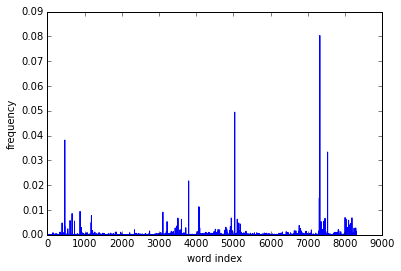

In [42]:
plt.plot(P_base)
plt.xlabel('word index')
plt.ylabel('frequency');

In [43]:
print([ivoc[i] for i in P_base.argsort()[::-1][:5]])
print(sorted(P_base)[::-1][:5])

['the', 'of', 'and', 'to', 'in']
[0.080353468880321952, 0.049455292548612188, 0.038205106504679551, 0.033368839757077697, 0.021727596662590724]


Now let's compute $P(year)$ and $P(word,year)$.

To do this, we'll write a function that returns a sum of word counts for a given year.

In [44]:
all_years = sorted(list(set([date.year for date in dates])))
print(all_years)

[1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865]


In [45]:
def get_X_year(X,dates,year):
    return np.array(X[[i for i,date in enumerate(dates) if date.year==year],].sum(axis=0))[0]

In [46]:
print(get_X_year(X,dates,1851))
print(X_1851.sum(axis=0))

[ 2 14  4 ...,  0  0  0]
[[ 2 14  4 ...,  0  0  0]]


Now let's create this vector for each year.

In [47]:
X_years = [get_X_year(X,dates,year) for year in all_years]

In [48]:
X_years[:3]

[array([ 0, 21,  3, ...,  2,  0,  0], dtype=int64),
 array([ 2, 11, 12, ...,  2,  3,  1], dtype=int64),
 array([47, 12,  5, ...,  0,  0,  1], dtype=int64)]

This is a list of arrays. We can combine this into a single array:

In [49]:
X_all_years = np.array(X_years)

In [50]:
P_year = X_all_years.sum(axis=1) / X_all_years.sum()

In [51]:
P_year

array([ 0.01411366,  0.02101902,  0.00972623,  0.04188513,  0.0143407 ,
        0.01494947,  0.0188828 ,  0.01691759,  0.05252363,  0.01493721,
        0.06889783,  0.06110763,  0.06352518,  0.06204324,  0.03534689,
        0.0140693 ,  0.02768742,  0.02650083,  0.01430919,  0.04323398,
        0.02164997,  0.01436113,  0.03003085,  0.02764773,  0.01518527,
        0.02963687,  0.01519111,  0.02934854,  0.01496873,  0.01472651,
        0.04676459,  0.01539072,  0.01451872,  0.0445951 ,  0.02996723])

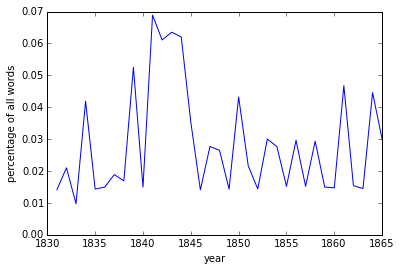

In [52]:
plt.plot(all_years,P_year)
plt.xlabel('year')
plt.ylabel('percentage of all words');

**Optional exercise** Create the same plot for months rather than years.

Now we're ready to compute the PMI.

In [53]:
all_years.index(1851)

20

In [54]:
X_all_years

array([[ 0, 21,  3, ...,  2,  0,  0],
       [ 2, 11, 12, ...,  2,  3,  1],
       [47, 12,  5, ...,  0,  0,  1],
       ..., 
       [ 0,  1, 10, ...,  0,  1,  0],
       [ 1, 20, 13, ...,  5,  2,  5],
       [ 1, 19,  6, ...,  3,  1,  1]], dtype=int64)

In [55]:
idx_1851 = all_years.index(1851)
pmi_1851 = np.log(X_all_years[idx_1851,:]/X_all_years.sum()) - np.log(P_base) - np.log(P_year[idx_1851])

That divide by zero error comes from taking the logarithm of zero, which will happen for every word that does not appear in the target year. Let's look at the output:

In [56]:
pmi_1851

array([-0.72112563,  0.1858105 , -0.8424113 , ...,        -inf,
              -inf,        -inf])

numpy handles this pretty well, putting a value of `-inf` in the list. 

that means we can go ahead and use argsort to find the highest PMI words.

In [57]:
[ivoc[i] for i in pmi_1851.argsort()[::-1][:5]]

['1851', 'austria', 'fraternity', 'problem', 'theyshould']

The top word is 1851! This is a good sign.

**Your turn** Write a function that takes the year as an argument, and returns the PMI for that year.

In [63]:
def get_pmi_year(X_all_years,P_base,p_year,year):
    # your code here
    idx_year = all_years.index(year)
    pmi_year = np.log(X_all_years[idx_year,:]/X_all_years.sum()) - np.log(P_base) - np.log(p_year[idx_year])
    return pmi_year

Here's how the output should look.

In [59]:
for year in all_years:
    print(year,[ivoc[i] for i in get_pmi_year(X_all_years,P_base,P_year,year).argsort()[::-1][:5]])

1831 ['weep', '1831', 'landlord', '1830', 'coach']
1832 ['cup', 'deaths', 'deputy', 'refute', 'cholera']
1833 ['planter', 'isle', 'spectator', '00', 'solomon']
1834 ['overseers', 'chorus', '1834', 'augusta', 'overseer']
1835 ['tracy', 'pull', '1835', 'purvis', 'madam']
1836 ['glasgow', 'opponent', 'kidnapped', 'boasting', 'searched']
1837 ['swallow', 'braintree', '1837', 'clerical', 'deprecate']
1838 ['mob', 'remonstrances', 'kidnappers', 'erected', 'nought']
1839 ['1839', 'harriet', 'disguise', 'marlboro', 'hilton']
1840 ['goodell', 'manifesto', 'harrison', 'follen', 'emancipator']
1841 ['1841', 'pierpont', 'lucretia', 'resistant', 'betrays']
1842 ['1842', 'trains', 'giddings', 'nelson', 'pauper']
1843 ['1843', 'stabbed', 'perkins', 'sham', 'bro']
1844 ['1844', 'birney', 'polk', 'bath', 'bates']
1845 ['writ', 'drunkenness', 'prosecuted', 'insurrections', 'employer']
1846 ['rio', 'drunkard', 'cobb', 'del', 'elegance']
1847 ['campbell', 'edinburgh', 'sand', 'thepoor', 'carved']
1848 ['1

These results suggest possibilities for further research: why was "drunkenness" a concern in 1845 and 1846, etc.

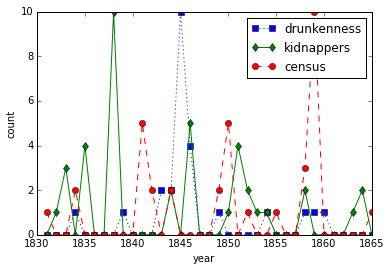

In [60]:
plt.plot(all_years,X_all_years[:,vect.vocabulary_['drunkenness']],'bs:')
plt.plot(all_years,X_all_years[:,vect.vocabulary_['kidnappers']],'gd-')
plt.plot(all_years,X_all_years[:,vect.vocabulary_['census']],'ro--')
plt.legend(['drunkenness','kidnappers','census'])
plt.ylabel('count')
plt.xlabel('year');

**Your turn**. Redo this analysis, using only words that appeared at least 50 times in the dataset.

In [65]:
# your code here
vect_50 = CountVectorizer(input='filename',min_df=50,binary=False)
X_50 = vect_50.fit_transform(files)
X_years_50 = [get_X_year(X_50,dates,year) for year in all_years]
X_all_years_50 = np.array(X_years_50)

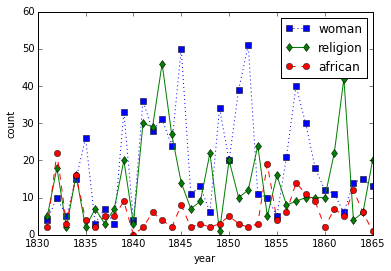

In [66]:
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['woman']],'bs:')
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['religion']],'gd-')
plt.plot(all_years,X_all_years_50[:,vect_50.vocabulary_['african']],'ro--')
plt.legend(['woman','religion','african'])
plt.ylabel('count')
plt.xlabel('year');

# Year-to-year similarity

Next, let's look for transitions in the data.

For each pair of years, we can compute the cosine similarity,

$\cos(x,y) = \frac{x \cdot y}{||x|| \times ||y||}$,

with $\cos(x,y) \in [0,1]$

In [67]:
corr = np.zeros(X_all_years.shape[0]-1)
for i,X_year in enumerate(X_all_years[:-1,]):
    corr[i] = X_year.dot(X_all_years[i+1,]) / ((np.linalg.norm(X_year)) * (np.linalg.norm(X_all_years[i+1,])))

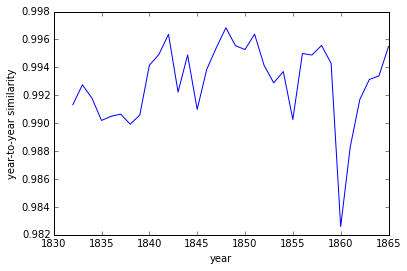

In [68]:
plt.plot(all_years[1:],corr)
plt.xlabel('year')
plt.ylabel('year-to-year similarity');

**Your turn:** Compute the cosine similarity of each year with the sum over the previous three years (when applicable)

In [69]:
offset = 3
corr_offset = [X_year.dot(X_all_years[i+offset,]) / (np.linalg.norm(X_year) * (np.linalg.norm(X_all_years[i+offset,]))) 
               for i, X_year in enumerate(X_all_years[:-offset])]

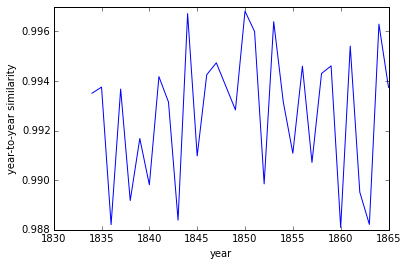

In [70]:
plt.plot(all_years[offset:],corr_offset)
plt.xlabel('year')
plt.ylabel('year-to-year similarity');

We see that these 3-year transitions are "spikier" but also contained in a smaller range than the 1-year transitions. More smoothing could separate long-term trends from random fluctuations.

## Lab extension: named entities during natural disaster
The dramatic change in social conditions during a natural disaster can result in significant linguistic variation: information shared is at a premium. 
During a disaster, news coverage often centers on named entities such as location names that are involved in the disaster ([Sarcevic et al. 2010](http://www.ischool.drexel.edu/faculty/aSarcevic/pub/p47-sarcevic.pdf)). 
Furthermore, if they are able to communicate, the victims of the disaster may provide more specific information about the situation than outside obsevers, including information on specific entities on-the-ground that were affected by the disaster ([Starbird, Muzny, Palen 2012](http://www.iscramlive.org/ISCRAM2012/proceedings/148.pdf)).

We pursue two research questions related to named entities in the context of Hurricane Maria, a storm that devastated Puerto Rico in late September 2017.

RQ1: Is the amount of named entity usage noticeably higher at the height of the disaster as compared to before and after the disaster?

RQ2: Does the distribution of named entity use change noticeably at the height of the disaster as compared to before and after the disaster?

Possible language-based RQs:

- More Spanish during hurricane?
- Bilingual individuals using more Spanish during hurricane?
- Less language similarity between days, users during hurricane (more surprising)?

To address this question, we use a dataset of tweets tagged with at least one of the hashtags `#Maria`, `#HurricaneMaria`, and `#PuertoRico` collected from September 18, 2017 through October 4, 2017. For reference, Hurricane Maria made landfall on Puerto Rico on September 20, 2017 and dissipated on October 3, 2017. 

## Load data

In [41]:
import pandas as pd
import os
import json
import gzip
data_dir = 'data/'
data_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.gz')]
tweet_matrix = [[l.decode('utf-8').strip().split('\t') for l in gzip.open(f, 'r')] for f in data_files]
tweet_df = pd.concat([pd.DataFrame(t[1:], columns=t[0]) for t in tweet_matrix], axis=0)
# need to reset index
tweet_df.reset_index(inplace=True)
print('loaded %d tweets'%(tweet_df.shape[0]))

loaded 246783 tweets


Let's remove hyperlinks, which might get mistagged as entities.

In [42]:
import re
# url_matcher = re.compile('https*://[\w\s\./]+|pic.twitter.com/[\w\./]+')
url_matcher = re.compile('https?://\S+|pic.twitter.com/\S+')
tweet_df.loc[:, 'text'] = tweet_df.loc[:, 'text'].apply(lambda x: url_matcher.sub('', x))
# also get rid of extra quotes
tweet_df.loc[:, 'text'] = tweet_df.loc[:, 'text'].apply(lambda x: x.replace('"', ''))

There's probably a lot of Spanish in here, but that actually isn't a bad thing because the hypotheses can still apply regardless of language.

In [45]:
from langid import classify
tweet_lang_list = tweet_df.loc[:, 'text'].apply(lambda x: classify(x)[0])
tweet_df.loc[:, 'lang'] = tweet_lang_list
tweet_lang_counts = tweet_lang_list.value_counts().sort_values(inplace=False, ascending=False)
print(tweet_lang_counts.head())

en    198248
es     32417
it      5289
fr      3965
la      1142
Name: text, dtype: int64


To stay sane, we will focus on just the English and Spanish tweets.

Write clean text to file for named entity recognition.

In [61]:
import codecs
valid_langs = ['en', 'es']
for lang in valid_langs:
    tweet_df_lang = tweet_df[tweet_df.loc[:, 'lang'] == lang]
    clean_txt_file = 'data/tweet_text_%s.txt'%(lang)
    with codecs.open(clean_txt_file, 'w') as clean_txt_output:
        N = tweet_df_lang.index.max()
        for i, l in zip(tweet_df_lang.index, tweet_df_lang.loc[:, 'text']):
            # need to include index to original dataframe
            l_clean = l.encode('utf-8').replace('\n', '')
            clean_txt_output.write('%d\t%s'%(i, l_clean))
            # add line break for every line except the last
            if(i < N):
                clean_txt_output.write('\n')

## Tag named entities

To tag named entities in English, we use the model developed by [Ritter et al. (2011)](https://aclanthology.info/pdf/D/D11/D11-1141.pdf), available for download [here](https://github.com/aritter/twitter_nlp).

To tag named entities in Spanish, we use the model developed as part of Stanford's CoreNLP package [here](http://nlp.stanford.edu/software/stanford-spanish-corenlp-2017-06-09-models.jar).

Outside of the notebook: 
- We run tag_english_txt.sh for the English data:

`bash tag_english_txt.sh`
- We run tag_spanish_txt.sh for the Spanish data (setup help [here](https://stackoverflow.com/questions/34037094/setting-nltk-with-stanford-nlp-both-stanfordnertagger-and-stanfordpostagger-fo)):

`bash tag_spanish_txt.sh`.

Let's check the results from both.

In [63]:
tweet_txt_tagged_en_file = 'data/tweet_text_en_ner.txt'
tweet_txt_tagged_es_file = 'data/tweet_text_es_ner.txt'
tweet_txt_tagged_en = [l.strip() for l in open(tweet_txt_tagged_en_file, 'r')]
tweet_txt_tagged_es = [l.strip() for l in open(tweet_txt_tagged_es_file, 'r')]

**English tags:**

In [65]:
print('\n'.join(tweet_txt_tagged_en[:10]))

1	#HurricaneMaria/O was/O Category/O ONE/O less/O than/O 18/O hours/O ago/O .../O @KRLD/O …/O
4	Will/O be/O a/O close/O call/O ,/O but/O some/O models/O take/O #Maria/O far/O enough/O north/O for/O the/O eyewall/O to/O miss/B-ENTITY Puerto/I-ENTITY Rico/I-ENTITY ./O
5	Here/O we/O go/O again/O Florida/B-ENTITY !/O #HurricaneMaria/O …/O
6	#Maria/B-ENTITY is/O now/O a/O Category/O 5/O with/O sustained/O winds/O of/O 160mph/O ./O Wow/O ./O
7	*/O #CARIBBEAN/O :/O MAJOR/B-ENTITY HURRICANE/I-ENTITY #MARIA/O -/O ALERT/B-ENTITY :/O #Dominica/O #Guadeloupe/O #Montserrat/B-ENTITY :/O Maria/B-ENTITY is/O now/O a/O .../O
9	#HurricaneMaria/O Category/O 5/O
10	DBS/B-ENTITY Radio/I-ENTITY plays/O religious/O music/O and/O talks/O over/O it/O .../O announcer/O just/O declared/O the/O sea/O was/O angry/O ./O #HurricaneMaria/O
11	JUST/O IN/O :/O Hurricane/O hunters/O flying/O through/O #Maria/O find/O sustained/O winds/O of/O 160/O mph/O ;/O the/O storm/O is/O now/O a/O Category/O 5/O
12	Trending/O now/O

**Spanish tags:**

In [66]:
print('\n'.join(tweet_txt_tagged_es[:10]))

0/O #URGENTE/O -/O HURACÁN/O #MARIA/O :/O Se/O dirige/O ahora/O a/O las/O islas/O Dominica/PERS y/O tiene/O vientos/O sostenidos/O de/O 257/O km/h/O ./O
2/O La/O probabilidad/O de/O que/O #María/O no/O nos/O parta/O tiene/O una/O correlación/O proporcional/O e/O inversa/O a/O la/O llegada/O de/O la/O Estadidad/LUG ./O
#TweetSerio/O 16/O El/O huracán/O Maria/PERS nos/O va/O a/O partir/O como/O crayola/O de/O kinder/O .../O #PrayForPuertoRico/O #PuertoRico/O #HuracanMaria/O #pauti/O @SOYJOSHUAPAUTA/O 25/O Con/O vientos/O sostenidos/O de/O 160mph/ORG ,/O #Maria/O se/O convierte/O en/O huracán/O categoría/O 5/O ./O
.../O 29/O Me/O tinca/O que/O mañana/O comenzarán/O las/O transmisiones/O en/O cadena/O nacional/O del/O huracán/O #Maria/O .../O 30/O a/O las/O 1900h/O #Maria/O es/O ahora/O categoria/O 5/O 37/O @COE_RD/O ordena/O evacuaciones/O preventivas/O a/O partir/O de/O mañana/O por/O huracán/O #María/O 40/O #URGENTE/O HURACÁN/O #MARIA/O :/O El/O Pdte/ORG Trump/ORG declara/O Estado/ORG d

In [47]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize.casual import TweetTokenizer
model_file = 'lib/stanford-spanish/edu/stanford/nlp/models/ner/spanish.ancora.distsim.s512.crf.ser.gz'
jar_file = 'lib/stanford-ner-2017-06-09/stanford-ner.jar'
tagger = StanfordNERTagger(model_filename=model_file, path_to_jar=jar_file)
tokenizer = TweetTokenizer()
test_sentences = tweet_df[tweet_df.loc[:, 'lang'] == 'es'].loc[:, 'text'][0:10]
for i, s in enumerate(test_sentences):
    s_tags = tagger.tag(tokenizer.tokenize(s))
    print('%d. original: %s'%(i, s))
    print('%d. tagged: %s'%(i, ' '.join(['/'.join(t) for t in s_tags])))

0. original: #URGENTE - HURACÁN #MARIA : Se dirige ahora a las islas Dominica y tiene vientos sostenidos de 257 km/h.
0. tagged: #URGENTE/O -/O HURACÁN/O #MARIA/O :/O Se/O dirige/O ahora/O a/O las/O islas/O Dominica/PERS y/O tiene/O vientos/O sostenidos/O de/O 257/O km/ORG /ORG h/ORG ./O
1. original: La probabilidad de que #María no nos parta tiene una correlación proporcional e inversa a la llegada de la Estadidad. #TweetSerio
1. tagged: La/O probabilidad/O de/O que/O #María/O no/O nos/O parta/O tiene/O una/O correlación/O proporcional/O e/O inversa/O a/O la/O llegada/O de/O la/O Estadidad/LUG ./O #TweetSerio/O
2. original: El huracán Maria nos va a partir como crayola de kinder ... #PrayForPuertoRico #PuertoRico #HuracanMaria #pauti @SOYJOSHUAPAUTA 
2. tagged: El/O huracán/O Maria/PERS nos/O va/O a/O partir/O como/O crayola/O de/O kinder/O .../O #PrayForPuertoRico/O #PuertoRico/O #HuracanMaria/O #pauti/O @SOYJOSHUAPAUTA/O
3. original: Con vientos sostenidos de 160mph, #Maria se convi

Some of these are pretty good!

- (2) `Maria` => `PERS`
- (3) `Estadidad` => `LUG` (lugar = "location")
- (7) `Pdte Trump` => `ORG`
- (7) `Puerto Rico` => `LUG`
- (8) `National Geographic` => `ORG`

Some are also pretty bad!

- (3) `160mph` => `ORG`
- (9) `huracán #Maria` => `O`

It seems like the good outweighs the bad, so let's do Spanish too.

## Sanity check: look at most popular named entities